In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.insert(0, "../code-previous")
sys.path.insert(0, "..")

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import sklearn.feature_extraction as skfeatures
import utils
import time
import os

import nltk
stopwords = nltk.corpus.stopwords.words('english')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt


path2rawdata = '/mnt/disks/vault/wos2017-parsed/'

In [4]:
raw_data_path = "/mnt/disks/vault/analysis-data/raw_data_full/raw_data_full.pql"
data = pd.read_pickle(raw_data_path)

In [5]:
# New fields to dataframe 
data['log_c5'] = data['c5'].progress_apply(lambda x: np.log(x+1))
data['character_count'] = data['Title'].progress_apply(lambda x: len(x))
data["word_count"] = data["Title"].progress_apply(lambda x: len(x.split()))
data['title_without_punct'] = data['Title'].progress_apply(lambda x: 
                                                           str.lower(''.join(ch for ch in str(x) if category(ch)[0] != 'P')))
data["title_without_stopwords"] = data['title_without_punct'].progress_apply(lambda x: 
                                                                            " ".join([word for word in x.split() if word not in stopwords]))


data["word_count"] = data["Title"].progress_apply(lambda x: len(x.split()))
data["cleaned_title_word_count"] = data["title_without_stopwords"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 738469/738469 [00:01<00:00, 612812.65it/s]


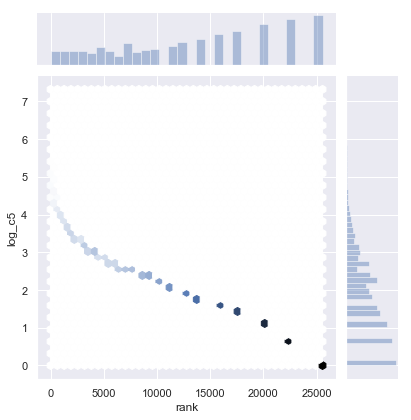

In [7]:
# consider just one year - 2009 for analysis
# Joint distribution between the title and rank

tmp = data[data.PubYear_x == 2005]
tmp = tmp.sort_values(by=['c5'],ascending=False)
tmp['rank'] = tmp.c5.rank(ascending=0,method='average')
g = sns.jointplot("rank", "log_c5", data=tmp, kind="hex", color="b")


# Some kind of a line - as expected!

In [40]:
# cumilative distributions
tmp["word_count_cum_sum"] = tmp['word_count'].cumsum()
tmp["rank_cum_sum"] = tmp['rank'].cumsum()

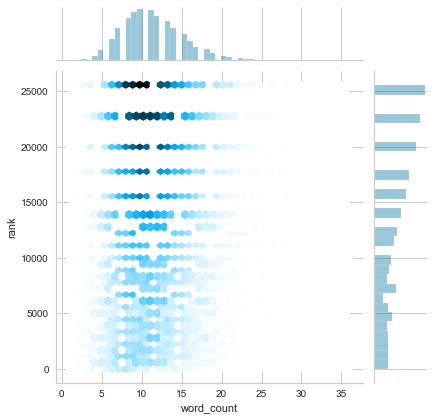

In [41]:
# Joint distribution between title word count and the rank
g = sns.jointplot("word_count", "rank", data=tmp, kind="hex", color="b")

In [42]:
# Mutual Information of the joint distribution of rank and character count

from sklearn.metrics import mutual_info_score
MI_title_without_stopwords_rank = mutual_info_score(tmp["character_count"], tmp["rank"])
MI_wordcount_rank = mutual_info_score(tmp["word_count"], tmp["rank"])
MI_charactercount_rank = mutual_info_score(tmp["character_count"], tmp["rank"])

print("Title without stop & Rank:", MI_title_without_stopwords_rank)
print("WordCount & Rank:", MI_wordcount_rank)
print("Charcater count & Rank:", MI_charactercount_rank)

Title without stop & Rank: 0.22512186316896776
WordCount & Rank: 0.05951430644168616
Charcater count & Rank: 0.22512186316896776


In [25]:
_tmp = tmp[["c5", "word_count"]]
_tmp.corr(method='pearson')

,c5,word_count
c5,1.000000,-0.076856
word_count,-0.076856,1.000000


In [26]:
_tmp = tmp[["c5","character_count"]]
_tmp.corr(method='pearson')

,c5,character_count
c5,1.000000,-0.052705
character_count,-0.052705,1.000000


In [27]:
_tmp = tmp[["c5","cleaned_title_word_count"]]
_tmp.corr(method='pearson')

,c5,cleaned_title_word_count
c5,1.000000,-0.064241
cleaned_title_word_count,-0.064241,1.000000


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


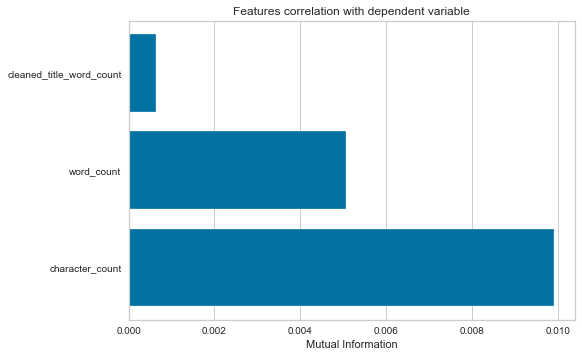

In [29]:

# too dependent on the random state


from yellowbrick.target import FeatureCorrelation

feature_names = ['character_count', 'word_count', 'cleaned_title_word_count']
X,y = tmp[feature_names],tmp['c5']
visualizer = FeatureCorrelation(method='mutual_info-regression',
                                labels=np.array(feature_names))

discrete_features = [False for _ in range(len(feature_names))]
visualizer.fit(X, y, discrete_features=discrete_features, random_state=20)
visualizer.poof()

In [ ]:
# computation of mutual information



